AudioDec Codec
https://github.com/facebookresearch/AudioDec
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10096509


pip install git+https://github.com/voidful/AudioDec.git

In [2]:
import nlp2
# download encoder
nlp2.download_file(
    'https://huggingface.co/AudioDecBenchmark/AudioDec/resolve/main/autoencoder/symAD_libritts_24000_hop300/checkpoint-500000steps.pkl',
    'audiodec_autoencoder_24k_320d')
nlp2.download_file(
    'https://huggingface.co/AudioDecBenchmark/AudioDec/resolve/main/autoencoder/symAD_libritts_24000_hop300/config.yml',
    "audiodec_autoencoder_24k_320d")
encoder_config_path = "audiodec_autoencoder_24k_320d/checkpoint-500000steps.pkl"

# download decoder
nlp2.download_file(
    'https://huggingface.co/AudioDecBenchmark/AudioDec/resolve/main/vocoder/AudioDec_v1_symAD_libritts_24000_hop300_clean/checkpoint-500000steps.pkl',
    'audiodec_vocoder_24k_320d')
nlp2.download_file(
    'https://huggingface.co/AudioDecBenchmark/AudioDec/resolve/main/vocoder/AudioDec_v1_symAD_libritts_24000_hop300_clean/config.yml',
    "audiodec_vocoder_24k_320d")
nlp2.download_file(
    "https://huggingface.co/AudioDecBenchmark/AudioDec/resolve/main/vocoder/AudioDec_v1_symAD_libritts_24000_hop300_clean/symAD_libritts_24000_hop300_clean.npy",
    "audiodec_vocoder_24k_320d"
)
decoder_config_path = "audiodec_vocoder_24k_320d/checkpoint-500000steps.pkl"

/home/lekhab/.conda/envs/codec_fake/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import os

current_dir = os.getcwd()

# Load audio signal file
male_voice_file_path = os.path.join(current_dir, "sample_9.wav")
female_voice_file_path = os.path.join(current_dir, "female_voice.wav")

In [ ]:
import torch
import numpy as np
import soundfile as sf
from AudioDec.utils.audiodec import AudioDec, assign_model
current_dir = os.getcwd()

encoder_config_path = "audiodec_autoencoder_24k_320d/checkpoint-500000steps.pkl"
decoder_config_path = "audiodec_vocoder_24k_320d/checkpoint-500000steps.pkl"


In [6]:
tx_device = "cuda:2"
rx_device = "cuda:2"

audiodec = AudioDec(tx_device=tx_device, rx_device=rx_device)
audiodec.load_transmitter(encoder_config_path)
audiodec.load_receiver(encoder_config_path, decoder_config_path)

/home/lekhab/.conda/envs/codec_fake/lib/python3.12/site-packages/AudioDec/utils/audiodec.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.l

Load tx_encoder: audiodec_autoencoder_24k_320d/checkpoint-500000steps.pkl
Load rx_encoder: audiodec_autoencoder_24k_320d/checkpoint-500000steps.pkl


/home/lekhab/.conda/envs/codec_fake/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/home/lekhab/.conda/envs/codec_fake/lib/python3.12/site-packages/AudioDec/utils/audiodec.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add

Load decoder: audiodec_vocoder_24k_320d/checkpoint-500000steps.pkl


In [8]:
sample_rate = 44100
output = "audio_dec_generated_file.wav"
with torch.no_grad():
        if os.path.exists(male_voice_file_path):
            data, fs = sf.read(male_voice_file_path, always_2d=True)
        else:
            raise ValueError(f'Input file {male_voice_file_path} does not exist!')
        assert fs == sample_rate, f"data ({fs}Hz) is not matched to model ({sample_rate}Hz)!"
        x = np.expand_dims(data.transpose(1, 0), axis=1) # (T, C) -> (C, 1, T)
        print(x.shape)
        x = torch.tensor(x, dtype=torch.float).to(tx_device)
        print("Encode/Decode...")
        z = audiodec.tx_encoder.encode(x)
        idx = audiodec.tx_encoder.quantize(z)
        zq = audiodec.rx_encoder.lookup(idx)
        y = audiodec.decoder.decode(zq)[:, :, :x.size(-1)]
        y = y.squeeze(1).transpose(1, 0).cpu().numpy() # T x C
        sf.write(
            output,
            y,
            fs,
            "PCM_16",
        )
        print(f"Output {output}!")

Encode/Decode...
Output audio_dec_generated_file.wav!


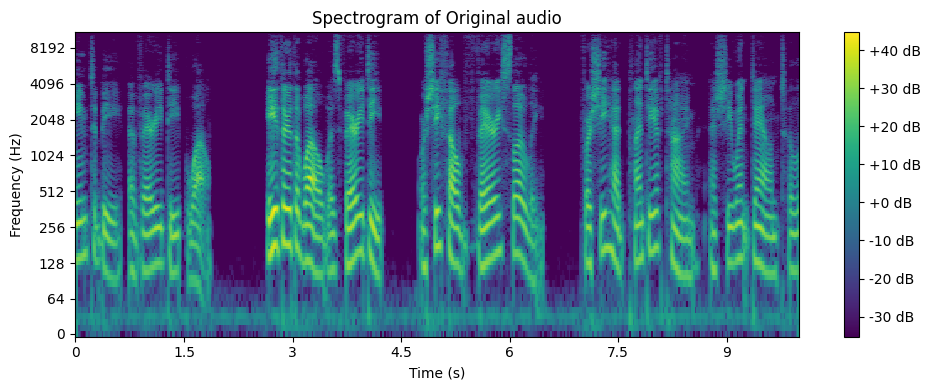

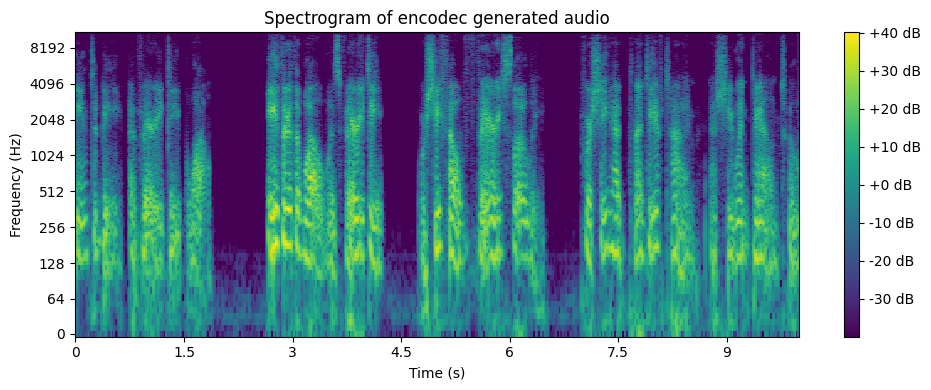

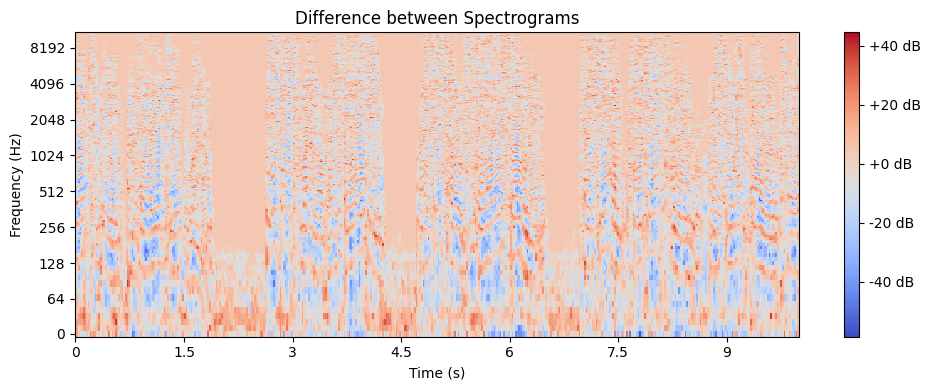

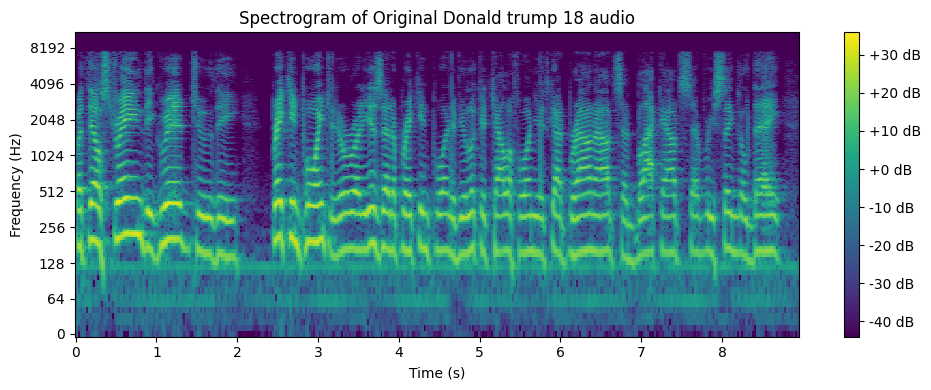

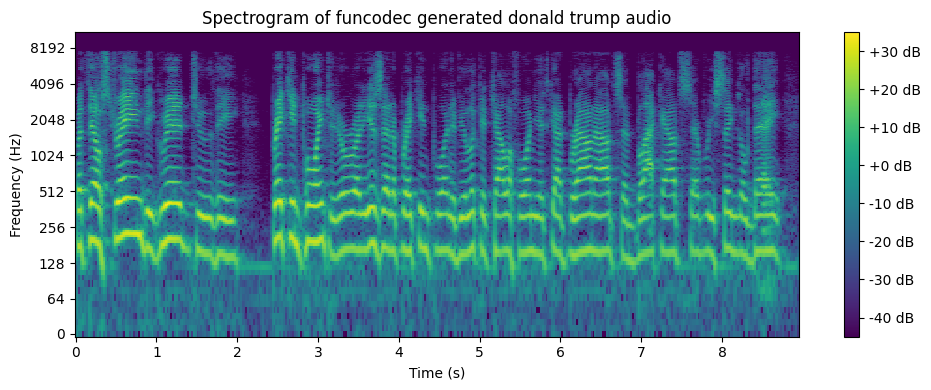

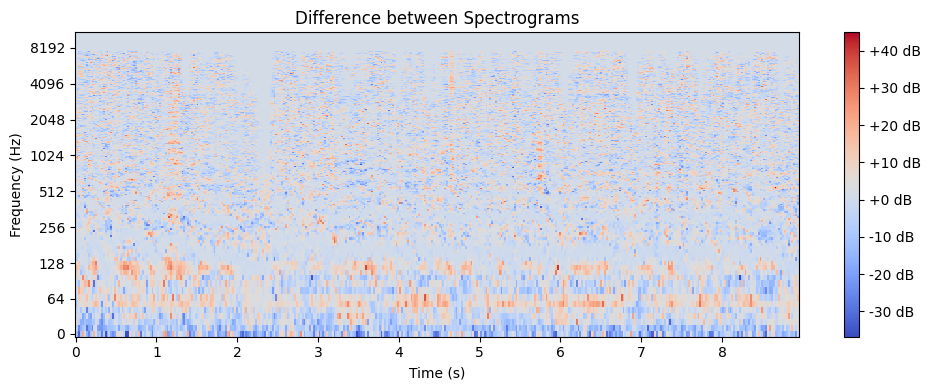

In [4]:
#Create spectograms for input and output audio files

import librosa
import librosa.display
import matplotlib.pyplot as plt

def plot_spectrogram(audio_file, title):
    # Load the audio file
    y, sr = librosa.load(audio_file)
    
    # Compute the STFT and convert to decibel scale
    stft = librosa.stft(y)
    spectrogram = librosa.amplitude_to_db(abs(stft))
    
    # Plot the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='log', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.tight_layout()
    plt.show()



def plot_spectrogram_difference(audio_file1, audio_file2):
    # Load and compute spectrograms for both audio files
    y1, sr1 = librosa.load(audio_file1)
    y2, sr2 = librosa.load(audio_file2)
    
    if sr1 != sr2:
        raise ValueError("Sample rates of the two audio files do not match. Please resample to the same rate.")
    
    # Compute the STFT for both signals
    stft1 = librosa.stft(y1)
    stft2 = librosa.stft(y2)
    
    # Convert to decibel scale
    spectrogram1 = librosa.amplitude_to_db(abs(stft1))
    spectrogram2 = librosa.amplitude_to_db(abs(stft2))
    
    # Compute the difference between the two spectrograms
    spectrogram_diff = spectrogram1 - spectrogram2
    
    # Plot the difference
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram_diff, sr=sr1, x_axis='time', y_axis='log', cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Difference between Spectrograms")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.tight_layout()
    plt.show()
# File paths for the two audio files
audio_file1 = 'sample_9.wav'  # original audio
audio_file2 = 'audio_dec_generated_file.wav'  # output audio file from dac
# female_audio_orig = "female_voice.wav"
# female_codec_fake = "academicodec_reconstructed_female_voice.wav"

# Plot spectrograms for both files
plot_spectrogram(audio_file1, title="Spectrogram of Original audio")
plot_spectrogram(audio_file2, title="Spectrogram of encodec generated audio")
plot_spectrogram_difference(audio_file1, audio_file2)
# plot_spectrogram(female_audio_orig, title="Spectrogram of Original female audio")
# plot_spectrogram(female_codec_fake, title="Spectrogram of encodec generated female audio")
# plot_spectrogram_difference(female_audio_orig, female_codec_fake)

# Plot spectrograms for both files
plot_spectrogram('/data/FF_V2/Famous_Figures_V2/Data/No_Laundering/no_laundering_s16/Donald_Trump_v2/train/Original/Donald_Trump_00018.wav',
                 title="Spectrogram of Original Donald trump 18 audio")
plot_spectrogram('/home/lekhab/AudioDeepfake/Donald_trum_funcodec.wav', 
                 title="Spectrogram of funcodec generated donald trump audio")
plot_spectrogram_difference('/data/FF_V2/Famous_Figures_V2/Data/No_Laundering/no_laundering_s16/Donald_Trump_v2/train/Original/Donald_Trump_00018.wav',
                            '/home/lekhab/AudioDeepfake/Donald_trum_funcodec.wav')


In [2]:
# Plot spectrograms for both files
plot_spectrogram('/data/FF_V2/Famous_Figures_V2/Data/No_Laundering/no_laundering_s16/Donald_Trump_v2/train/Original/Donald_Trump_00018.wav',
                 title="Spectrogram of Original audio")
plot_spectrogram('/home/lekhab/AudioDeepfake/Donald_trum_funcodec.wav', 
                 title="Spectrogram of encodec generated audio")
plot_spectrogram_difference('/data/FF_V2/Famous_Figures_V2/Data/No_Laundering/no_laundering_s16/Donald_Trump_v2/train/Original/Donald_Trump_00018.wav',
                            '/home/lekhab/AudioDeepfake/Donald_trum_funcodec.wav')

NameError: name 'plot_spectrogram' is not defined

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

import os
import torch
import numpy as np
import soundfile as sf
from AudioDec.utils.audiodec import AudioDec, assign_model
current_dir = os.getcwd()

# audio file_path
file_path = os.path.join(current_dir, "sample_9.wav")


def process_audio(input_file, output_file, model_name="vctk_v1", cuda_device=0, num_threads=4):
    """
    Encode and decode an audio file using the AudioDec model.

    Args:
        input_file (str): Path to the input .wav file.
        output_file (str): Path to save the output .wav file.
        model_name (str): Name of the AudioDec model to use (default: vctk_v1).
        cuda_device (int): CUDA device index (-1 for CPU, 0 or higher for GPU).
        num_threads (int): Number of threads for computation.
    """
    # Assign devices
    if cuda_device < 0:
        tx_device = "cpu"
        rx_device = "cpu"
    else:
        tx_device = f"cuda:{cuda_device}"
        rx_device = f"cuda:{cuda_device}"
    torch.set_num_threads(num_threads)

    # Assign model
    sample_rate, encoder_checkpoint, decoder_checkpoint = assign_model(model_name)

    # Initialize AudioDec
    print("Initializing AudioDec...")
    audiodec = AudioDec(tx_device=tx_device, rx_device=rx_device)
    audiodec.load_transmitter(encoder_checkpoint)
    audiodec.load_receiver(encoder_checkpoint, decoder_checkpoint)

    # Process audio
    if not os.path.exists(input_file):
        raise FileNotFoundError(f"Input file {input_file} does not exist!")

    data, fs = sf.read(input_file, always_2d=True)
    if fs != sample_rate:
        raise ValueError(f"Input sample rate ({fs}Hz) does not match model sample rate ({sample_rate}Hz)!")

    x = np.expand_dims(data.transpose(1, 0), axis=1)  # (T, C) -> (C, 1, T)
    x = torch.tensor(x, dtype=torch.float).to(tx_device)

    print("Encoding and decoding the audio...")
    with torch.no_grad():
        z = audiodec.tx_encoder.encode(x)
        idx = audiodec.tx_encoder.quantize(z)
        zq = audiodec.rx_encoder.lookup(idx)
        y = audiodec.decoder.decode(zq)[:, :, :x.size(-1)]
        y = y.squeeze(1).transpose(1, 0).cpu().numpy()  # (T, C)

    # Save the output audio
    sf.write(output_file, y, fs, "PCM_16")
    print(f"Processed audio saved to {output_file}!")


if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser(description="Process audio using AudioDec model.")
    parser.add_argument("-i", "--input", type=str, required=True, help="Path to input .wav file")
    parser.add_argument("-o", "--output", type=str, required=True, help="Path to output .wav file")
    parser.add_argument("--model", type=str, default="vctk_v1", help="Model to use (default: vctk_v1)")
    parser.add_argument("--cuda", type=int, default=0, help="CUDA device index (-1 for CPU, default: 0)")
    parser.add_argument("--num_threads", type=int, default=4, help="Number of threads (default: 4)")
    args = parser.parse_args()

    process_audio(
        input_file=args.input,
        output_file=args.output,
        model_name=args.model,
        cuda_device=args.cuda,
        num_threads=args.num_threads,
    )


usage: ipykernel_launcher.py [-h] -i INPUT -o OUTPUT [--model MODEL]
                             [--cuda CUDA] [--num_threads NUM_THREADS]
ipykernel_launcher.py: error: the following arguments are required: -i/--input, -o/--output


SystemExit: 2

/home/lekhab/.conda/envs/codec_fake/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
